# Film dosimetry

## Prerequisites


* Films have to be separated by a minimum distance of 5 mm between them.
* Films have to be aligned with respect to the sides of the scanner.
* The image should have three channels, red, blue and green (RGB).

This is a common example for film calibration. 

![example scanned films](../assets/cal_example_v2.png)

Optionaly, optical filters are added as a quality control test for error detection. For example if auto correction of color or brightness has been applied unconsciously. Also, as a way to measure inter-scan reproducibility of the lamp/detector system.

## Usage

Start importing the load funtion and LUT class.

In [2]:
from Dosepy.image import load
from Dosepy.calibration import LUT

Handle the tiff file for film calibration

In [3]:
path_to_file = "/home/luis/Documents/cal.tif"

cal_image = load(path_to_file)

TypeError: The argument '/home/luis/Documents/cal.tif' was not found to be                        a valid file.

Create a LUT object to manage calibration with the image as argument. 

In [3]:
cal = LUT(cal_image)

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11


Dosepy automatically detects and enumerates each object in the image.

Create central rois on each film and show.

<Axes: >

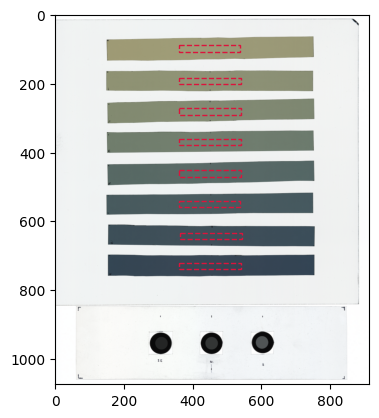

In [4]:
cal.set_central_rois()

cal.plot_rois()

Change the ROI size to 16 x 8 mm

<Axes: >

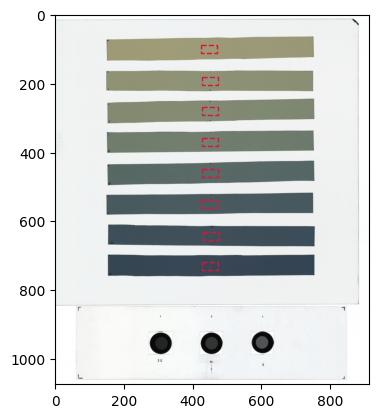

In [5]:
cal.set_central_rois(size = (16, 8))
cal.plot_rois()

To setup the **cal** object we need to perform the following step:

* Set the imparted doses to the film in Gy in a list.
* Compute the lut 
* Optional, apply a filer of size of 3 pixels for noise reduction.

In [6]:

cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])

cal.compute_central_lut(filter=3)

## Show results

Plot the calibration curve, using the red channel and a rational function

$$ y = -c + \frac{b}{x-a} $$

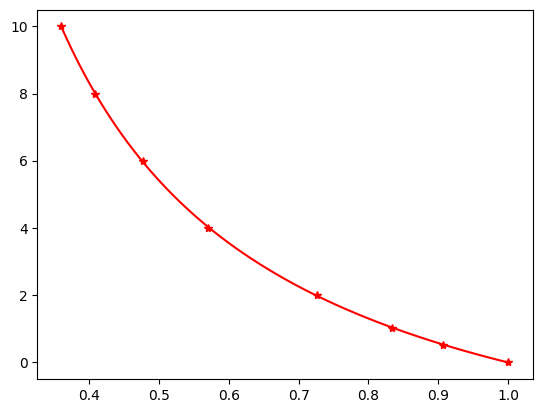

In [7]:
cal.plot_fit("rational", "red")

Plot dose uncertainty 

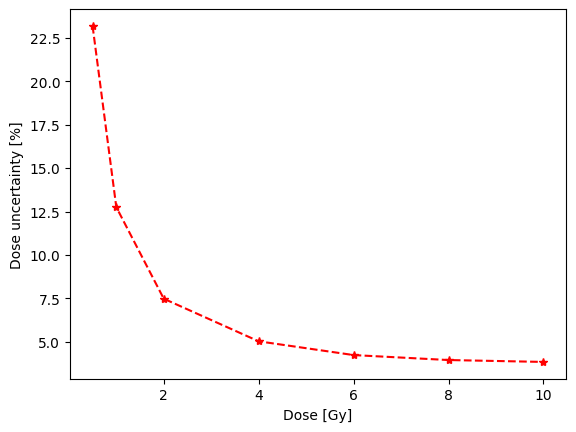

In [16]:
cal.plot_dose_fit_uncertainty(fit_function="rational", channel = "red")

## Lateral correction

Correction for lateral response artifact is done by computing a calibration curve at every milimeter in lateral direction. 

To set-up the lut, we need to load a relative dose profile of the field used for film irradiation. In this example, a 6 MV beam of size 150 mm x 150 mm, 5 mm deep was used for film calibration. 

The file must have an array of two columns:

* First column should be for positions, given in mm, with 0 being at center.

* Second column should be the relative values [%], normalized to 100 at center.

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11


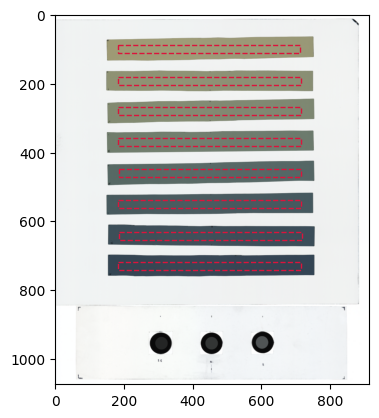

In [9]:
cal = LUT(cal_image)

cal.set_central_rois(size = (180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])
cal.plot_rois()

cal.set_beam_profile("/home/luis/Documents/BeamProfile.csv")

Next we need to call the **compute_lateral_lut()** (instead of compute_central_lut())

In [10]:
cal.compute_lateral_lut(filter=3)

(Optional) show green intensity values on lateral direction

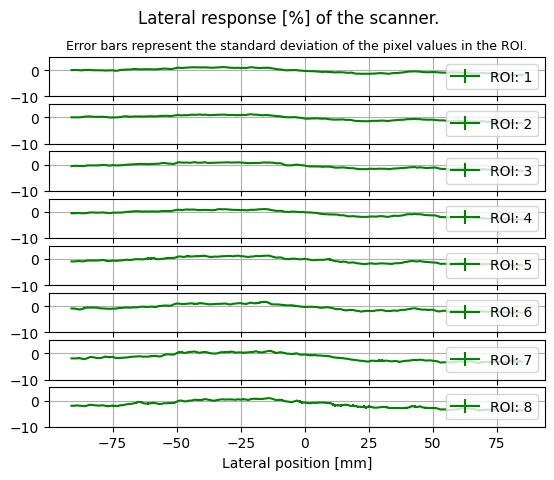

In [11]:
cal.plot_lateral_response(channel="green")

We can use the green channel and a polynomial fit function of the form

$$  y = ax + bx^n $$

_get_dose_from_fit
calib_response
[-0.          0.02505817  0.04714712  0.0877384   0.16429744  0.22839677
  0.28568504  0.34049264]


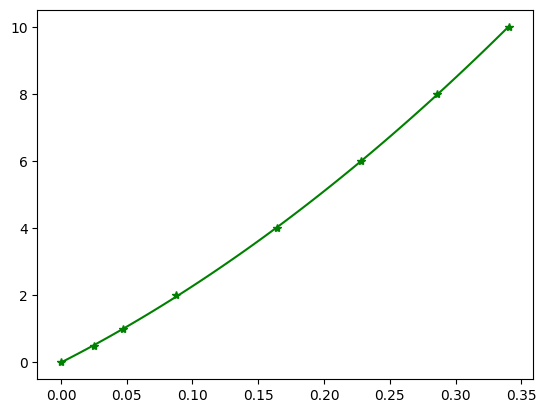

In [12]:
cal.plot_fit("polynomial", "green")

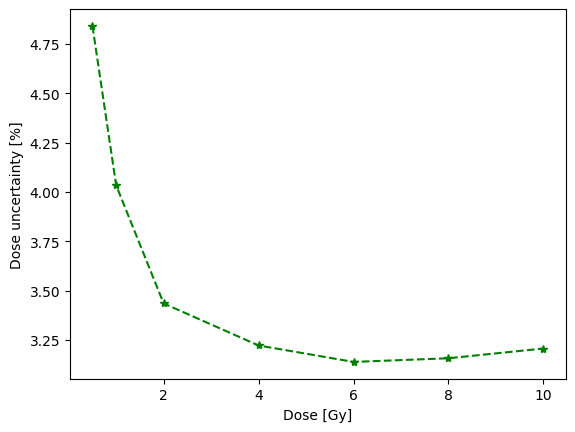

In [13]:
cal.plot_dose_fit_uncertainty(position=0, fit_function="polynomial", channel="green")

## Load multiple files for noise reduction

TODO

## Quality control using optical filters

TODO

## Film to dose

Load another tif file.

```{note}
Additionaly to the film to be transformed to dose, the scanned image must also have one unirradiated film. It is used as a reference for 0 Gy.
```

In [14]:
qa_image_path = "/home/luis/Documentos/test_file.tif"
qa_image = load(qa_image_path)
qa_image.plot()

FileNotFoundError: [Errno 2] No such file or directory: '/home/luis/Documentos/test_file.tif'

Apply the calibration curve

In [5]:
dose_img = qa_image.to_dose(cal)

Plot it

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(ncols=1)

max_dose = np.percentile(dose_img.array, [99.9])[0]
pos = ax.imshow(dose_img.array, cmap='nipy_spectral')
pos.set_clim(-.05, max_dose)

# add a colorbar
fig.colorbar(pos, ax=ax)
plt.plot()

Get mean doses from central rois, 20 mm width and 8 mm hight, in each founded films.

In [ ]:
doses_in_central_rois = qa_image.doses_in_central_rois(cal, roi = (20, 8), show=True)
print(doses_in_central_rois)

Save the dose distribution as a tif file (in cGy) useful for further analysis using [ImageJ](https://imagej.net/ij/).

In [8]:
dose_img.save_as_tif("dose_in_tif_file")

Save as csv file

In [9]:
# np.savetxt("some_name.txt", dose_img.array, fmt = '%.3f', delimiter = ',')